In [24]:
import pandas as pd

df = pd.read_csv('../data/engineered_retail_data.csv', parse_dates=['Date'])
df = df.sort_values(['product_id', 'Date']).reset_index(drop=True)

# ---- Add extra lag features ----
df['lag_2'] = df.groupby('product_id')['Total_Purchases'].shift(2)
df['lag_3'] = df.groupby('product_id')['Total_Purchases'].shift(3)

# ---- Rolling median ----
df['roll_7_median'] = df.groupby('product_id')['Total_Purchases'].shift(1).rolling(7).median()
df['roll_30_median'] = df.groupby('product_id')['Total_Purchases'].shift(1).rolling(30).median()

# ---- Rolling min/max ----
df['roll_7_min'] = df.groupby('product_id')['Total_Purchases'].shift(1).rolling(7).min()
df['roll_7_max'] = df.groupby('product_id')['Total_Purchases'].shift(1).rolling(7).max()

# ---- EWMA ----
df['ewm_7'] = df.groupby('product_id')['Total_Purchases'].shift(1).ewm(span=7, adjust=False).mean()
df['ewm_30'] = df.groupby('product_id')['Total_Purchases'].shift(1).ewm(span=30, adjust=False).mean()

# Fill missing values created by lags/rolls
df = df.fillna(0)

df.to_csv('../data/engineered_retail_data_catboost_final.csv', index=False)

df.head()


,State,Country,Date,Total_Purchases,Product_Category,Product_Brand,Product_Type,products,product_id,Year,...,roll_30_mean,roll_30_std,lag_2,lag_3,roll_7_median,roll_30_median,roll_7_min,roll_7_max,ewm_7,ewm_30
0,england,united kingdom,2023-03-11,3.0,electronics,sony,television,4k_tv,0,2023,...,6.033333,2.772815,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,new south wales,australia,2023-03-11,4.0,electronics,sony,television,4k_tv,0,2023,...,5.966667,2.797577,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,3.000000
2,georgia,usa,2023-03-11,9.0,electronics,sony,television,4k_tv,0,2023,...,6.166667,2.792642,3.0,0.0,0.0,0.0,0.0,0.0,3.250000,3.064516
3,berlin,germany,2023-03-11,4.0,electronics,samsung,television,4k_tv,0,2023,...,6.233333,2.712466,4.0,3.0,0.0,0.0,0.0,0.0,4.687500,3.447451
4,new south wales,australia,2023-03-11,6.0,electronics,samsung,television,4k_tv,0,2023,...,6.200000,2.708862,9.0,4.0,0.0,0.0,0.0,0.0,4.515625,3.483099


In [25]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

df = pd.read_csv('../data/engineered_retail_data_catboost_final.csv')

# Time-based split
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')



train_df = df[df['Date'] < '2024-01-01']
test_df  = df[df['Date'] >= '2024-01-01']

target = 'Total_Purchases'

# CatBoost can take raw categorical columns
cat_features = ['State','Country','Product_Category','Product_Brand','Product_Type','products']

features = [c for c in df.columns if c not in ['Total_Purchases','Date']]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# model = CatBoostRegressor(
#     iterations = 1500,
#     depth = 10,
#     learning_rate = 0.03,
#     loss_function = 'RMSE',
#     eval_metric = 'RMSE',
#     random_seed = 42,
#     task_type = 'CPU',  # change to CPU if no GPU
#     early_stopping_rounds = 80
# )

# model.fit(
#     X_train, y_train,
#     eval_set=(X_test, y_test),
#     cat_features=cat_features,
#     verbose=200
# )

# pred = model.predict(X_test)

from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    median_absolute_error
)
import numpy as np

# ---- Existing Metrics ----
# mae = mean_absolute_error(y_test, pred)
# rmse = np.sqrt(mean_squared_error(y_test, pred))

# # ---- Additional Metrics ----
# # MAPE (avoid divide by zero)
# mape = np.mean(np.abs((y_test - pred) / (y_test + 1e-8))) * 100

# # SMAPE
# smape = 100 * np.mean(
#     2 * np.abs(y_test - pred) / (np.abs(y_test) + np.abs(pred) + 1e-8)
# )
# y_test_clipped  = np.maximum(y_test, 0)
# pred_clipped    = np.maximum(pred, 0)
    

# # R2 Score
# r2 = r2_score(y_test, pred)
# # Median Absolute Error
# medae = median_absolute_error(y_test, pred)

# RMSLE
# rmsle = np.sqrt(mean_squared_error(
#     np.log1p(y_test_clipped),
#     np.log1p(pred_clipped)
# ))



# # Print all metrics
# print("CatBoost Test MAE:", mae)
# print("CatBoost Test RMSE:", rmse)
# print("CatBoost Test MAPE:", mape)
# print("CatBoost Test SMAPE:", smape)
# print("CatBoost Test R²:", r2)
# print("CatBoost Test Median AE:", medae)
# print("CatBoost Test RMSLE:", rmsle)



In [26]:
# pred = model.predict(X_test)


In [27]:
# test_df['Predicted'] = pred

# daily_actual = test_df.groupby('Date')['Total_Purchases'].sum()
# daily_pred = test_df.groupby('Date')['Predicted'].sum()


In [28]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14,6))
# plt.plot(daily_actual.index, daily_actual.values, label='Actual', linewidth=2)
# plt.plot(daily_pred.index, daily_pred.values, label='Predicted', linewidth=2)
# plt.title("Actual vs Predicted Total Purchases (Daily Sum)")
# plt.xlabel("Date")
# plt.ylabel("Purchases")
# plt.legend()
# plt.grid(True)
# plt.show()


In [29]:
# ===========================================
# IMPORTS
# ===========================================
import numpy as np
import pandas as pd

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error
)

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# ===========================================
# METRIC FUNCTIONS
# ===========================================

def mape(y, yhat):
    return np.mean(np.abs((y - yhat) / (y + 1e-8))) * 100

def smape(y, yhat):
    return 100 * np.mean(
        2 * np.abs(y - yhat) / (np.abs(y) + np.abs(yhat) + 1e-8)
    )

def rmsle(y, yhat):
    y_clip = np.maximum(y, 0)
    yhat_clip = np.maximum(yhat, 0)
    return np.sqrt(
        mean_squared_error(np.log1p(y_clip), np.log1p(yhat_clip))
    )

def mase(y_true, y_pred):
    # naive forecast error (lag-1)
    naive = y_true.shift(1)
    return mean_absolute_error(y_true[1:], y_pred[1:]) / \
           mean_absolute_error(y_true[1:], naive[1:])

def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE (%)": mape(y_true, y_pred),
        "SMAPE (%)": smape(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
        "Median AE": median_absolute_error(y_true, y_pred),
        "RMSLE": rmsle(y_true, y_pred),
        "MASE": mase(y_true, y_pred)
    }


# ===========================================
# TRAIN / TEST SPLIT
# ===========================================

df = df.sort_values(['product_id', 'Date']).reset_index(drop=True)

# Time-based split
train = df[df['Date'] < '2024-01-01']
test  = df[df['Date'] >= '2024-01-01']

X_train = train[features]
y_train = train[target]

X_test  = test[features]
y_test  = test[target]


In [30]:

# ===========================================
# TRAIN MODELS
# ===========================================
cat_features = [
    'State',
    'Country',
    'Product_Category',
    'Product_Brand',
    'Product_Type',
    'products',
    'product_id'
]
print("Training CatBoost...")
cat_model = CatBoostRegressor(
    depth=10,
    learning_rate=0.05,
    n_estimators=600,
    loss_function='RMSE',
    verbose=False
)

cat_model.fit(
    X_train,
    y_train,
    cat_features=cat_features
)
cat_pred = cat_model.predict(X_test)

X_train_xgb = X_train.copy()
X_test_xgb  = X_test.copy()
cat_cols = ['State', 'Country', 'Product_Category', 'Product_Brand', 
            'Product_Type', 'products', 'product_id']

for col in cat_cols:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_test_xgb[col]  = X_test_xgb[col].astype('category')



Training CatBoost...


In [31]:
print("Training XGBoost...")
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    enable_categorical=True
)

xgb.fit(X_train_xgb, y_train)
xgb_pred = xgb.predict(X_test_xgb)



Training XGBoost...


In [32]:

print("Training LightGBM...")
lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=80,
    subsample=0.9,
    colsample_bytree=0.9
)

for col in cat_cols:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_test_xgb[col]  = X_test_xgb[col].astype('category')

lgb.fit(X_train_xgb, y_train, categorical_feature=cat_cols)
lgb_pred = lgb.predict(X_test_xgb)



# ===========================================
# ENSEMBLE
# ===========================================

w1, w2, w3 = 0.6, 0.2, 0.2

final_pred = (
    w1 * cat_pred +
    w2 * xgb_pred +
    w3 * lgb_pred
)


# ===========================================
# EVALUATION TABLE
# ===========================================

results = []
results.append(evaluate_model("CatBoost", y_test, cat_pred))
results.append(evaluate_model("XGBoost", y_test, xgb_pred))
results.append(evaluate_model("LightGBM", y_test, lgb_pred))
results.append(evaluate_model("Ensemble", y_test, final_pred))

results_df = pd.DataFrame(results)
print("\n=========== MODEL PERFORMANCE (ALL METRICS) ===========")
print(results_df)


Training LightGBM...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 241073, number of used features: 35
[LightGBM] [Info] Start training from score 5.362679

=========== MODEL PERFORMANCE (ALL METRICS) ===========
      Model       MAE      RMSE   MAPE (%)  SMAPE (%)        R²  Median AE  \
0  CatBoost  1.004732  1.261683  31.596869  25.529214  0.807832   0.845333   
1   XGBoost  1.105414  1.384531  35.054041  27.327895  0.768588   0.933139   
2  LightGBM  1.045162  1.313134  32.553773  26.069

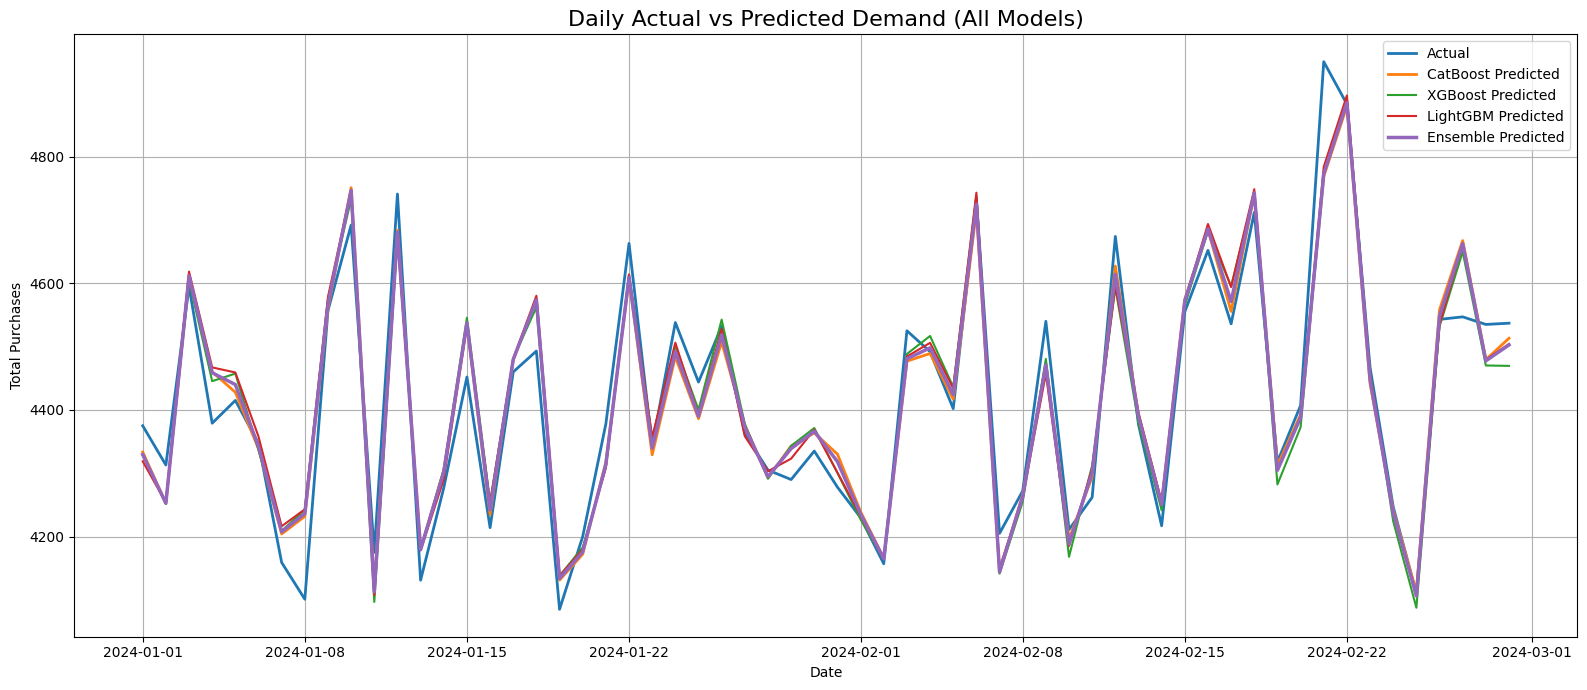

In [33]:
import matplotlib.pyplot as plt

# ==========================
# Daily Aggregation
# ==========================
plot_df = X_test.copy()
plot_df["Actual"] = y_test.values
plot_df["CatBoost"] = cat_pred
plot_df["XGBoost"] = xgb_pred
plot_df["LightGBM"] = lgb_pred
plot_df["Ensemble"] = final_pred

daily = plot_df.groupby(plot_df.index.map(lambda i: df.loc[i, "Date"])).sum()

# ==========================
# PLOT
# ==========================
plt.figure(figsize=(16,7))
plt.plot(daily.index, daily["Actual"], label="Actual", linewidth=2)
plt.plot(daily.index, daily["CatBoost"], label="CatBoost Predicted", linewidth=2)
plt.plot(daily.index, daily["XGBoost"], label="XGBoost Predicted", linewidth=1.5)
plt.plot(daily.index, daily["LightGBM"], label="LightGBM Predicted", linewidth=1.5)
plt.plot(daily.index, daily["Ensemble"], label="Ensemble Predicted", linewidth=2.5)

plt.title("Daily Actual vs Predicted Demand (All Models)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchases")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
import matplotlib.pyplot as plt

# Build a dataframe with predictions + actual
plot_df = X_test.copy()
plot_df["Actual"] = y_test.values
plot_df["CatBoost"] = cat_pred
plot_df["XGBoost"] = xgb_pred
plot_df["LightGBM"] = lgb_pred
plot_df["Ensemble"] = final_pred

# Aggregate by Date
daily = plot_df.groupby(test["Date"]).sum()


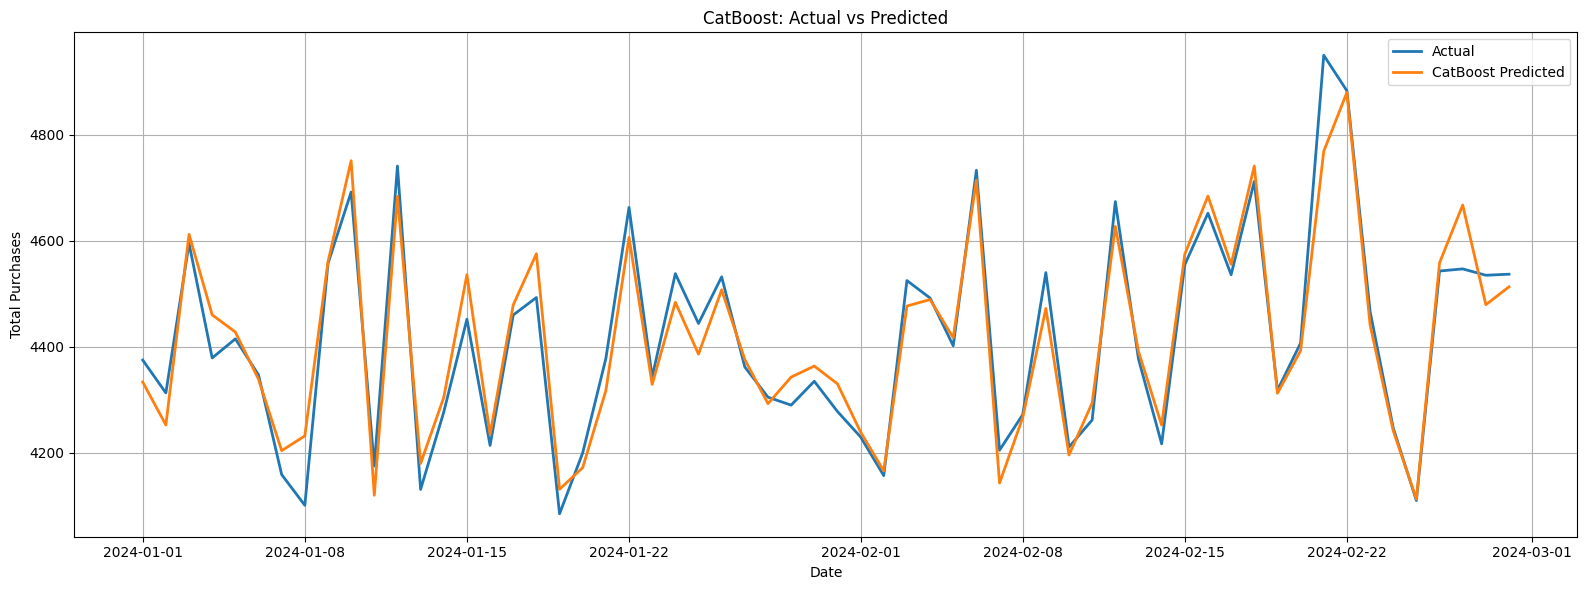

In [35]:
plt.figure(figsize=(16,6))
plt.plot(daily.index, daily["Actual"], label="Actual", linewidth=2)
plt.plot(daily.index, daily["CatBoost"], label="CatBoost Predicted", linewidth=2)

plt.title("CatBoost: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Total Purchases")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


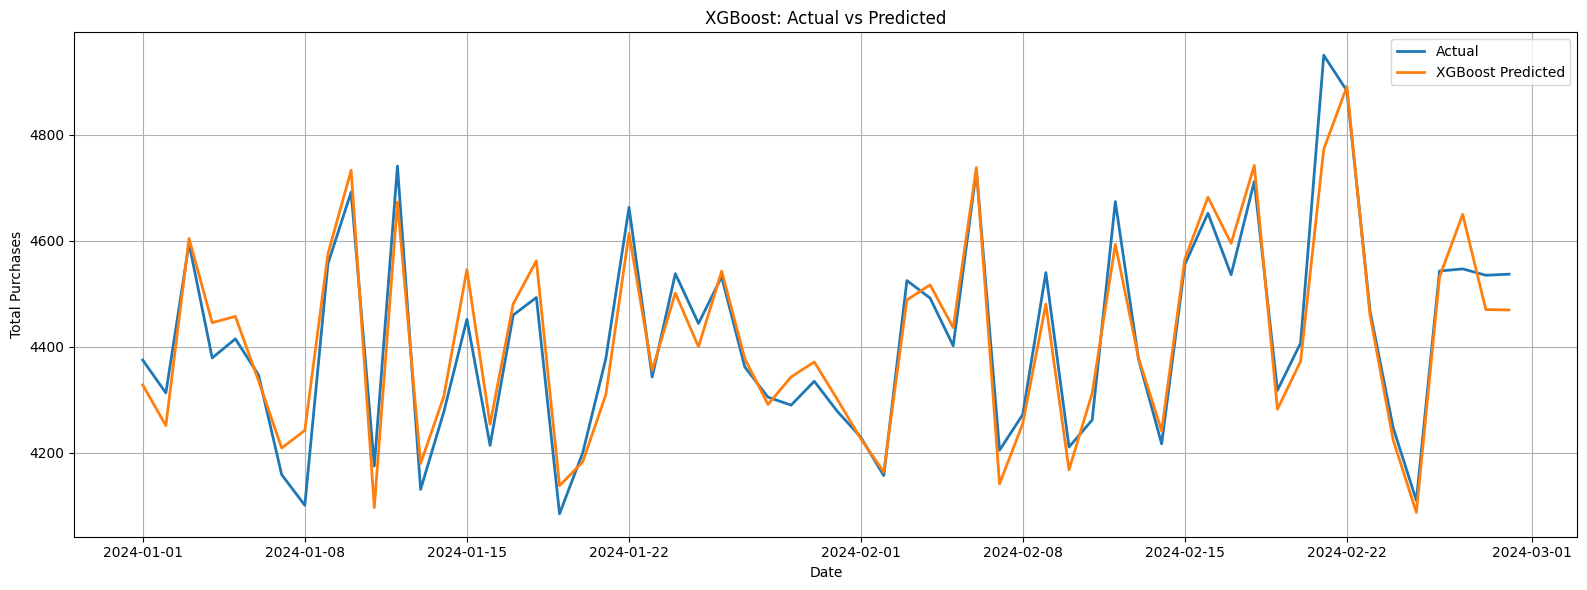

In [36]:
plt.figure(figsize=(16,6))
plt.plot(daily.index, daily["Actual"], label="Actual", linewidth=2)
plt.plot(daily.index, daily["XGBoost"], label="XGBoost Predicted", linewidth=2)

plt.title("XGBoost: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Total Purchases")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


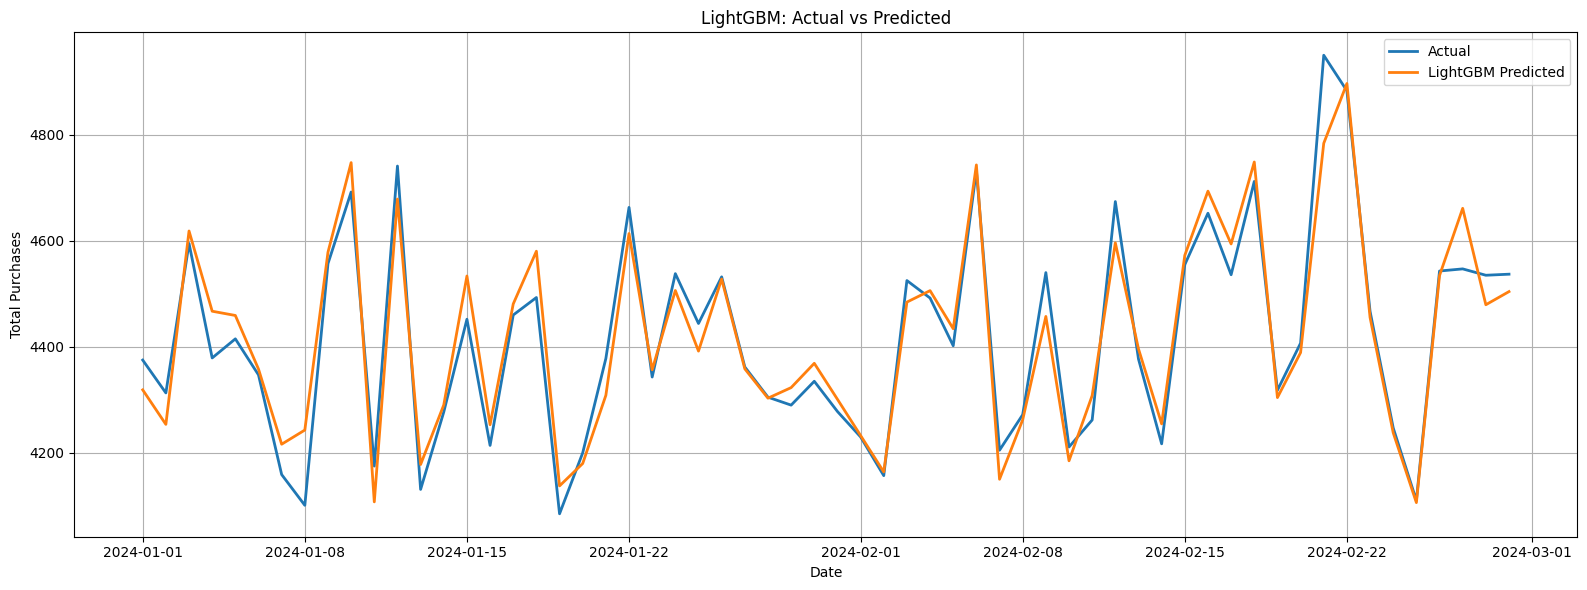

In [37]:
plt.figure(figsize=(16,6))
plt.plot(daily.index, daily["Actual"], label="Actual", linewidth=2)
plt.plot(daily.index, daily["LightGBM"], label="LightGBM Predicted", linewidth=2)

plt.title("LightGBM: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Total Purchases")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


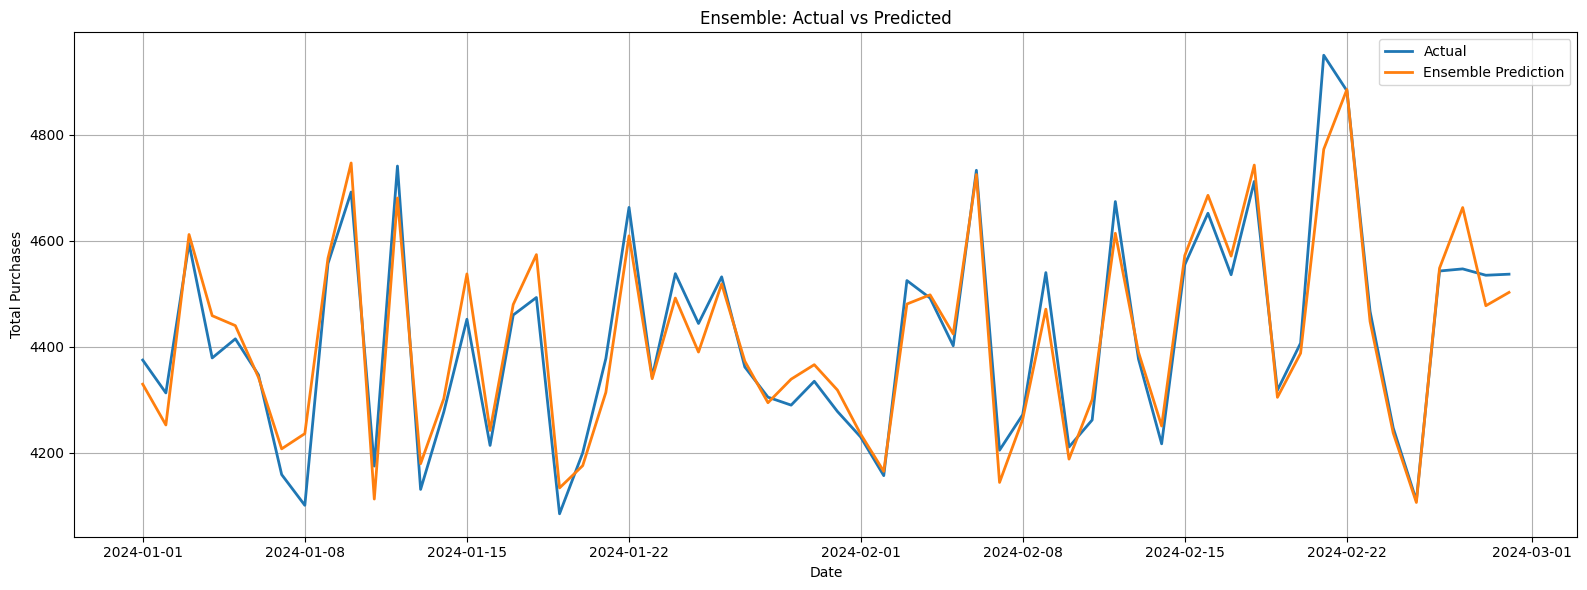

In [38]:
plt.figure(figsize=(16,6))
plt.plot(daily.index, daily["Actual"], label="Actual", linewidth=2)
plt.plot(daily.index, daily["Ensemble"], label="Ensemble Prediction", linewidth=2)

plt.title("Ensemble: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Total Purchases")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
